In [31]:
import os
import pandas as pd
import time
#import pymagnitude 
import matplotlib.pyplot as plt
import numpy as np

#librairie pour les fonction de features
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')


In [32]:
# if necesseray install the Natural Language Toolkit (NLTK) in Python
#!pip install nltk

In [33]:
# if necesseray install the Natural Language Toolkit (NLTK) in Python
#install POT and pyemd necessary to use the Gensim's WMD implementation 
# POT = Python Optimal Transport library
# pyemd = Python Earth Mover's Distance library)
#%pip install gensim
#%pip install POT
#%pip install pyemd 

In [34]:
! pwd
#!cd c:\Users\anaele.baudant\'OneDrive - BEFIVE'

'pwd' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [35]:
#BUG
#from features import load_data, preprocess_dataset

In [36]:
#reprise des fonctions load_data preprocess_sentence et preprocess_dataset

def load_data():
    data = dict()
    #for fn in os.listdir("stsbenchmark"):
    for fn in os.listdir("stsbenchmark"):
        if fn.endswith(".csv"):
            with open("stsbenchmark/" + fn,encoding='utf-8') as f:
                subset = fn[:-4].split("-")[1]
                #logger.info(f"subset: %s", subset)
                data[subset] = dict()
                data[subset]['data'] = []
                data[subset]['scores'] = []
                for l in f:
                    # genre filename year score sentence1 sentence2 (and sources, sometimes)
                    l = l.strip().split("\t")
                    data[subset]['data'].append((l[5], l[6]))
                    data[subset]['scores'].append(float(l[4]))
    return data

def preprocess_sentence(sentence):
    stemmer = PorterStemmer()
    # tokenize and lower case
    tokens = word_tokenize(sentence.lower())
    # stemming and removing stop words
    stemmed_tokens = [stemmer.stem(token) for token in tokens if not token in set(
        stopwords.words('english'))]
    # remove punctuations
    filtered_tokens = [
        token for token in stemmed_tokens if token not in punctuation]
    # return ' '.join(filtered_tokens) # Anaele supprimé ici et intégré dans preprocess_dataset()
    return filtered_tokens  # renvoie une liste (vecteur de la phrase)

def preprocess_dataset(dataset):
    df = pd.DataFrame(dataset)

    df[['s1', 's2']] = df['data'].apply(lambda x: pd.Series(x))
    df['sm'] = df['s1'] + " " + df['s2']  # merged sentences
    # preprocessing des phrases 1 et 2 en vecteur ou string :
    df['token_1'] = df['s1'].apply(preprocess_sentence)  # vecteur
    df['token_2'] = df['s2'].apply(preprocess_sentence)  # vecteur
    df['token_m'] = df['sm'].apply(preprocess_sentence)  # vecteur
    df['s1_pp'] = df['token_1'].apply(' '.join)  # string
    df['s2_pp'] = df['token_2'].apply(' '.join)  # string
    df['sm_pp'] = df['token_m'].apply(' '.join)  # string
    df['scores_norm'] = df['scores'] / 5  # normalisation du score entre 0 et 1
    # Replace empty strings with NaN
    df.replace('', np.nan, inplace=True)

    # Store the index labels before dropna
    index_before_dropna = df.index

    # Drop rows with NaN values
    df.dropna(inplace=True)

    df.reset_index(drop=True)

    # Store the index labels after dropna
    index_after_dropna = df.index

    # Get the index labels that were dropped
    dropped_indexes = index_before_dropna.difference(index_after_dropna)

    return df


In [37]:
#chargement de la base de donnée
dataset=load_data()
df_dev = pd.DataFrame(dataset['dev'])
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_train.head()

,data,scores
0,"(A plane is taking off., An air plane is takin...",5.00
1,"(A man is playing a large flute., A man is pla...",3.80
2,(A man is spreading shreded cheese on a pizza....,3.80
3,"(Three men are playing chess., Two men are pla...",2.60
4,"(A man is playing the cello., A man seated is ...",4.25


In [38]:
#Exploration des données :
#print('structure de dataset:',dataset.keys())
#print('structure de data[\'test\']:',dataset['test'].keys())
#print('structure de df_test:',df_test.keys())

In [39]:
#pre-processing
df_dev_pp = preprocess_dataset(df_dev)
df_train_pp = preprocess_dataset(df_train)
df_test_pp = preprocess_dataset(df_test)

In [40]:
#cd c:\Users\anaele.baudant\GoogleNews-vectors-negative300
#%cd c:\Users\anaele.baudant\GoogleNews-vectors-negative300
#%pwd

In [41]:
#MODEL KeyedVerctors de Word2vec (extension .bin)
# à partir du fichier à télécharger préalablement: GoogleNews-vectors-negative300.bin
# https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download
# !!! ficher fait 1,5 GB compressé et 3,6 GB décompressé !!!

from gensim.models import KeyedVectors

#path = 'c:\Users\anaele.baudant\GoogleNews-vectors-negative300\GoogleNews-vectors-negative300.bin\'
file='GoogleNews-vectors-negative300.bin'

# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format(file, binary=True)   

def remove_OOV(text):
    '''removes words in sentence that is not found in the vocabulary
    OOV=out of vocabulary'''
    return [word for word in doc if word in model.key_to_index]


In [42]:
#illustration du modele KeyedVectors
dog = model['dog']
cat = model['cat']
dogs = model['dogs']

print("6 premieres valeurs des vecteurs (de dimension",dog.shape[0],')')
print('dog',dog[:6])
print('dogs',dogs[:6])
print('cat',cat[:6])

# calcul de la distance avec wmdistance (Word Mover's Distance (WMD))
#distance sur R+ / si résultat = inf (infiny) il y a une erreur (word out of vocabulary ou pb format)
distance1 = model.wmdistance('cat', 'dog')
distance2 = model.wmdistance('dog', 'dogs')
distance3 = model.wmdistance('dog', 'philosophy')

print('\ndistance cat dog:',distance1)
print('distance dog dogs:',distance2)
print('distance dog philosophy:',distance3)

6 premieres valeurs des vecteurs (de dimension 300 )
dog [ 0.05126953 -0.02233887 -0.17285156  0.16113281 -0.08447266  0.05737305]
dogs [-0.02050781 -0.01245117 -0.12792969  0.21777344 -0.140625    0.02612305]
cat [ 0.0123291   0.20410156 -0.28515625  0.21679688  0.11816406  0.08300781]

distance cat dog: 1.0106912030917452
distance dog dogs: 0.29174261808811397
distance dog philosophy: 0.7649682443081849


In [43]:
#test word out of vocabulary => pas pris en compte
doc1 =['cat','on','table','dflkjdsqlkmfjdsfdlk']
#doc1=['plane', 'take']
doc2 = [word for word in doc1 if word in model.key_to_index]
print('doc1 :',doc1,'\ndoc2 :',doc2)
print('distance doc1 - doc2:',model.wmdistance(doc1, doc2),'\n')
# génération d'un score infini=probleme (ici format d'entrée non valable car
# input = liste d'un seul string (phrase) et string non reconnu dans vocabulaire)
s1 =['cat on table dflkjdsqlkmfjdsfdlk']
s2 =['cat on table dflkjdsqlkmfjdsfdlk']
print('s1 :',s1,'\ns2 :',s2)
print('distance s1 - s2:',model.wmdistance(s1, s2))

doc1 : ['cat', 'on', 'table', 'dflkjdsqlkmfjdsfdlk'] 
doc2 : ['cat', 'on', 'table']
distance doc1 - doc2: 0.0 

s1 : ['cat on table dflkjdsqlkmfjdsfdlk'] 
s2 : ['cat on table dflkjdsqlkmfjdsfdlk']
distance s1 - s2: inf


In [46]:
 doc1!=doc2

True

In [48]:
df_train_pp.shape[0]

5749

In [62]:
def WMD_score(df,s1,s2,m=1):
    """Calcule la distance WMD et les scores associé entre les phrases de 2 colonnes
    Attributes:
        df: The pandas dataframe
        s1: The label of the first sentence (can be a string  or list of strings)
        s2: The label of the second sentence (can be a string  or list of strings)
        m: coefficient for the exponential score
    """
    for i in range(df.shape[0]):

        s1v=df[s1].iloc[i]
        s2v=df[s2].iloc[i]
        #retire les mots pas dans le vocabulaire
        s1v=[word for word in s1v if word in model.key_to_index]
        s2v=[word for word in s2v if word in model.key_to_index]
        #calcule distance WMD
        distance_wmd=model.wmdistance(s1v,s2v)
        df.loc[i, 'distance_WMD'] = distance_wmd
        #transformation distance en score normalisé (entre 0 et 1)
        df.loc[i, 'scores_WMD_exp'] = 1-distance_wmd
        df.loc[i, 'scores_WMD_inv'] = np.exp(-distance_wmd*m)
    df['scores_WMD_max'] = 1-df['distance_WMD']/df['distance_WMD'].max()
    return df

def WMD_score_str(df,m=1):
    '''Calcule la distance WMD et les scores associé entre deux phrases dans un tupple (dataset non processé)'''
    for i in range(df.shape[0]):
        #retire les mots pas dans le vocabulaire
        s=df.iloc[i,0]
        s1v=s[0]
        s2v=s[1]
        #s1v=[word for word in s1v if word in model.key_to_index]
        #s2v=[word for word in s2v if word in model.key_to_index]
        #calcule distance et scores associés
        distance_wmd=model.wmdistance(s1v,s2v)
        df.loc[i, 'distance_WMD'] = distance_wmd
        df.loc[i, 'scores_WMD_inv'] = 1-distance_wmd
        df.loc[i, 'scores_WMD_exp'] = np.exp(-distance_wmd*m)
    df['scores_WMD_max'] = 1-df['scores_WMD']/df['scores_WMD'].max()
    return df

In [74]:
#WMD score on non-pre-processed data
#WMD_score_str(df_train)
#WMD_score2(df_train_pp,'token_1','token_2')
#WMD_score(df_train_pp,'token_1','token_2')
#df_train[['s1','s2','scores_init','distance_WMD','scores_WMD_inv','scores_WMD_exp','scores_WMD_max']].head()

In [63]:
#####################################################
# 1. WMD score on non-pre-processed data (strings)  #
#####################################################
WMD_score(df_train_pp,'s1','s2')
#WMD_score(df_train_pp,'token_1','token_2')
'df_train_pp[['s1','s2','scores_norm','distance_WMD','score_WMD_inv','scores_WMD_exp','scores_WMD_max']].head()'

SyntaxError: invalid syntax (2264089203.py, line 6)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

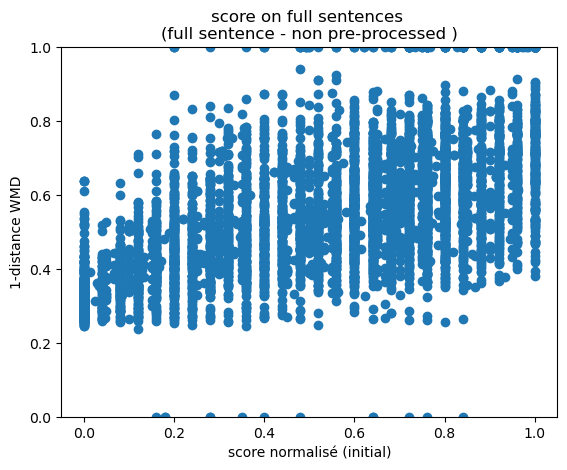

In [67]:
# score initial (x) et 1-score_pwd (y) NON PREPROCESSED
plt.scatter(df_train_pp['scores_norm'],df_train_pp['scores_WMD_inv'])#),'.',color='red')
#plt.scatter(df_train['scores_init'],df_train['scores_WMD_exp'])
plt.xlabel('score normalisé (initial)',fontsize=10)
plt.ylabel('1-distance WMD',fontsize=10)
plt.axis(ymax = 1,ymin=0)
plt.title('score on full sentences \n(full sentence - non pre-processed )')
plt.plot

In [68]:
##################################################
# 2. WMD score on pre-processed data (vecteurs)  #
##################################################
WMD_score(df_train_pp,'token_1','token_2')
df_train_pp[['token_1','token_2','scores_norm','distance_WMD','scores_WMD_inv','scores_WMD_exp','scores_WMD_max']].head()

,token_1,token_2,scores_norm,distance_WMD,scores_WMD_inv,scores_WMD_exp,scores_WMD_max
0,"[plane, take]","[air, plane, take]",1.00,0.417267,0.658845,0.582733,1.0
1,"[man, play, larg, flute]","[man, play, flute]",0.76,0.338564,0.712793,0.661436,1.0
2,"[man, spread, shrede, chees, pizza]","[man, spread, shred, chees, uncook, pizza]",0.76,0.334131,0.715960,0.665869,1.0
3,"[three, men, play, chess]","[two, men, play, chess]",0.52,0.094085,0.910205,0.905915,1.0
4,"[man, play, cello]","[man, seat, play, cello]",0.85,0.338632,0.712744,0.661368,1.0


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

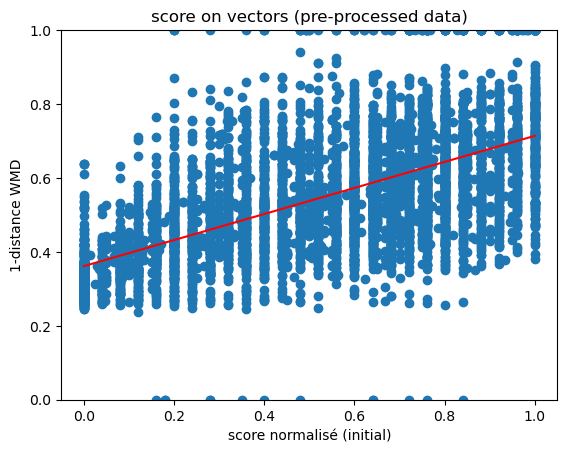

In [73]:
# score initial (x) et 1-score_pwd (y) NON PREPROCESSED
x , y = df_train_pp['scores_norm'] , df_train_pp['scores_WMD_inv']
m, b = np.polyfit(x,y, 1)
plt.scatter(x,y)#),'.',color='red')
#plt.scatter(df_train['scores_init'],df_train['scores_WMD_exp'])
plt.plot(x, m*x + b, color='red')
plt.xlabel('score normalisé (initial)',fontsize=10)
plt.ylabel('1-distance WMD',fontsize=10)
plt.axis(ymax = 1,ymin=0)
plt.title('score on vectors (pre-processed data)')
plt.plot

In [249]:
#création d'un score matriciel

def WMD_matrix(df,s1,s2,will_print=0):
    if 'matrix_WMD' in df.columns : df = df.drop('matrix_WMD', axis=0)
    N=500#df.shape[0]
    Res=array_of_matrices = np.empty((N,5), dtype=object)
    print(Res.shape)
    for i in range(N):
        
        s1v=df[s1].iloc[i]
        s2v=df[s2].iloc[i]
        #retire les mots pas dans le vocabulaire
        s1v=[word for word in s1v if word in model.key_to_index]
        s2v=[word for word in s2v if word in model.key_to_index]
        if len(s1v)==0 or len(s2v)==0:
            df.loc[i,'scores_WMD_matrix']=0
            Res[i,3]=df['scores_norm'].iloc[i]
            Res[i,4]=0
        else:
            M=np.zeros((len(s1v),len(s2v)))
        
            #calcule distance WMD mot à mot
            for x in range(len(s1v)):
                for y in range(len(s2v)):
                    M[x,y]=distance_wmd=model.wmdistance(s1v[x],s2v[y])
        
            #calculate score and save in matrix:
            try:
                max=np.max(M)
            except ValueError as e:
                max = 1  # or some other default value or action
        #max=np.max(M)
            M_inv=(1-M/max)
            score=M_inv.sum()/(len(s1v)*len(s2v))*2
            df.loc[i,'scores_WMD_matrix']=score
        
            #save results in Res
            Res[i,0]=M
            Res[i,1]=M_inv
            Res[i,2]=pd.DataFrame(M_inv,columns=s2v, index=s1v)
            Res[i,3]=df['scores_norm'].iloc[i]
            Res[i,4]=score
        #else:
        #    df.loc[i,'scores_WMD_matrix']="NA"
        #    Res[i,]=["NA","NA","NA","NA","NA"]
        
        #impression de la WMD_matrice
            if will_print==1:
                #print('\n',s1v,'\n',s2v)#,'\n',M)
                print('scores_norm/WMD_matrix/diff:',round(df['scores_norm'].iloc[i],2),round(Res[i,4],2),round(df['scores_norm'].iloc[i]-Res[i,4],2))#,'\n',M_inv)#,'\n',M)
                print(pd.DataFrame(M_inv,columns=s2v, index=s1v))
        #print(pd.DataFrame(M,columns=s2v, index=s1v))

        #df.loc[i, 'matrice_WMD_pd'] = pd.DataFrame(M,columns=s2v, index=s1v)
        #print(s1v,'\n',s2v,'\n',df.loc[i, 'scores_norm'],'\n',df.loc[i, 'matrice_WMD_pd'])
        #transformation distance en score normalisé (entre 0 et 1)
        #df.loc[i, 'scores_WMD_exp'] = 1-distance_wmd
        #df.loc[i, 'scores_WMD_inv'] = np.exp(-distance_wmd*m)
    #df['scores_WMD_max'] = 1-df['distance_WMD']/df['distance_WMD'].max()
    return Res

In [250]:
#df_train_pp.head()

In [251]:
res_matrix=WMD_matrix(df_train_pp,'token_1','token_2')
#res_matrix.head()

(500, 5)


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

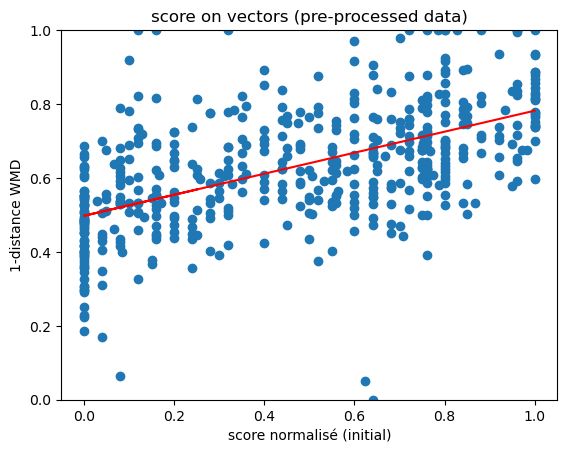

In [254]:

# score initial (x) et 1-score_pwd (y) NON PREPROCESSED
x , y = df_train_pp['scores_norm'] , df_train_pp['scores_WMD_matrix']
x=x[:500]
y=y[:500]
m, b = np.polyfit(x,y, 1)
plt.scatter(x,y)#),'.',color='red')
#plt.scatter(df_train['scores_init'],df_train['scores_WMD_exp'])
plt.plot(x, m*x + b, color='red')
plt.xlabel('score normalisé (initial)',fontsize=10)
plt.ylabel('1-distance WMD',fontsize=10)
plt.axis(ymax = 1,ymin=0)
plt.title('score on vectors (pre-processed data)')
plt.plot

In [267]:
def MSE(X, Y):
    if len(X) == len(Y):
        npX = np.array(X)
        npY = np.array(Y)
        MSE = ((npY - npX.mean())**2).sum()/len(npX)
    else:
        "les deux vecteurs fournis doivent etre de meme dimension pour calculer le MSE"
    return MSE

def coeff_colelation(X, Y):
    if len(X) == len(Y):
        npX = np.array(X)
        npY = np.array(Y)
        cov = ((npX - npX.mean())*(npY - npY.mean())).sum()/len(npX)
    else:
        "les deux vecteurs fournis doivent etre de meme dimension pour calculer le coefficient de corrélation"
    coeff = cov / (npX.std()*npY.std())
    return coeff

def show_stats(df, initial, feature):
    X = df[str(initial)]
    Y = df[str(feature)]
    error = X-Y
    print('Le score moyen (initial) est de :', round(
        X.mean(), 2), '(écart type de', round(X.std(), 2), ')')
    print('Le score moyen de la feature est de :', round(
        Y.mean(), 2), '(écart type de', round(Y.std(), 2), ')')
    print('L\'erreur est en moyenne de :', round(error.mean(), 2),
          '(écart type de', round(error.std(), 2), ')')
    print('Le coefficient de corélation de "', str(initial), '" et "',
          str(feature), '" est :', round(coeff_colelation(X, Y), 2))
    print('Le MSE est de :', round(MSE(X, Y), 2))
    
#res_matrix[:100,3:5]
print('scores_WMD')
show_stats(df_train_pp.loc[:500,:], 'scores_norm' , 'scores_WMD_inv')
print('\nscores_WMD_matrix')
show_stats(df_train_pp.loc[:500,:], 'scores_norm' , 'scores_WMD_matrix')

scores_WMD
Le score moyen (initial) est de : 0.47 (écart type de 0.33 )
Le score moyen de la feature est de : 0.54 (écart type de 0.19 )
L'erreur est en moyenne de : -0.07 (écart type de 0.23 )
Le coefficient de corélation de " scores_norm " et " scores_WMD_inv " est : 0.72
Le MSE est de : 0.04

scores_WMD_matrix
Le score moyen (initial) est de : 0.47 (écart type de 0.33 )
Le score moyen de la feature est de : 0.63 (écart type de 0.17 )
L'erreur est en moyenne de : -0.16 (écart type de 0.27 )
Le coefficient de corélation de " scores_norm " et " scores_WMD_matrix " est : 0.56
Le MSE est de : 0.05


In [246]:
# ________________________________________________________________________________
#|                                                                               |
#|                  MODEL Magnitude de Word2vec (extension .magnitude)           |
#|_______________________________________________________________________________|
# à partir du fichier à télécharger préalablement: GoogleNews-vectors-negative300.bin
# http://magnitude.plasticity.ai/word2vec/medium/GoogleNews-vectors-negative300.magnitude
# !!! fichier fait 4,9 Go !!!

#### How pymagnitude works
from pymagnitude import *

# Loading vectors
## TO COMPLETE : specify the path to the magnitude file in ""
# magnitude file to download from word2vec
file='GoogleNews-vectors-negative300.magnitude'
vectors = Magnitude(path)

# This is how you obtain the vector for a word (for example, "cat"):
cat_vector = vectors.query("cat")

ModuleNotFoundError: No module named 'annoy'

In [146]:
# Install the Pymagnitude word embedding library
# !!! this may take some time (around 5 minutes) !!!
t=time.time()
! pip install pymagnitude
print('\ntemps de telechargement de pymagnitude (en seconde):',round(time.time()-t,6),'s')

DEPRECATION: Loading egg at c:\users\anaele.baudant\anaconda3\lib\site-packages\pymagnitude-0.1.143-py3.11-win-amd64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
ERROR: You must give at least one requirement to install (see "pip help install")


  Using cached annoy-1.17.3.tar.gz (647 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for annoy
Failed to build annoy

temps de telechargement de pymagnitude (en seconde): 14.974116 s


DEPRECATION: Loading egg at c:\users\anaele.baudant\anaconda3\lib\site-packages\pymagnitude-0.1.143-py3.11-win-amd64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [22 lines of output]
  C:\Users\anaele.baudant\anaconda3\Lib\site-packages\setuptools\__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!
    dist.fetch_build_eggs(dist.setup_requires)
  running bdist_wheel
  running build
  running build_py
  creating buil

In [148]:
! pip install --use-pep517
! pip install annoy

ERROR: You must give at least one requirement to install (see "pip help install")


  Using cached annoy-1.17.3.tar.gz (647 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for annoy
Failed to build annoy


DEPRECATION: Loading egg at c:\users\anaele.baudant\anaconda3\lib\site-packages\pymagnitude-0.1.143-py3.11-win-amd64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [22 lines of output]
  C:\Users\anaele.baudant\anaconda3\Lib\site-packages\setuptools\__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!
    dist.fetch_build_eggs(dist.setup_requires)
  running bdist_wheel
  running build
  running build_py
  creating buil